In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif
from interpret import glassbox

In [2]:
df = pd.read_csv('Doceree-HCP_Train.csv', encoding='latin1')

In [3]:
df.head()

,ID,DEVICETYPE,PLATFORM_ID,BIDREQUESTIP,USERPLATFORMUID,USERCITY,USERZIPCODE,USERAGENT,PLATFORMTYPE,CHANNELTYPE,URL,KEYWORDS,TAXONOMY,IS_HCP
0,1001,Desktop,2,170.173.0.22,6974dcaa-f932-480e-9fb5-c52e20e1393a,Portland,97206.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/canc...,General|Endocrine|False|Medicine|Surgery|Urolo...,NaN,0.0
1,1002,Desktop,2,65.216.253.25,c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf,Arlington,22202.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/deci...,Bone Marrow|Radiography|Chronic|Oncology|Psych...,NaN,0.0
2,1003,Desktop,2,66.232.79.22,a698de4b-e200-46dd-b5fb-40402175ae18,New Meadows,83654.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/canc...,General|Endocrine|False|Medicine|Surgery|Urolo...,NaN,0.0
3,1004,Desktop,3,137.54.125.246,45967533-75c8-4fbd-a00c-e6ff20447aaa,NaN,229114624.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,https://globalrph.com/medcalcs/warfarin-mainte...,Dental|Total|Clinical|Pharmacology|Physicians|...,2084P0800X,1.0
4,1005,Mobile,7,174.202.231.99,a17e25be-532d-4cf5-b916-9308c8c3961f,Houston,77008.0,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1_1 like...,Online Medical Journal,Website,https://www.cureus.com/articles/58184-a-review...,Critical Care|Emergency Medicine|General Pract...,NaN,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               113937 non-null  int64  
 1   DEVICETYPE       113937 non-null  object 
 2   PLATFORM_ID      113937 non-null  int64  
 3   BIDREQUESTIP     113937 non-null  object 
 4   USERPLATFORMUID  113933 non-null  object 
 5   USERCITY         107578 non-null  object 
 6   USERZIPCODE      109345 non-null  float64
 7   USERAGENT        113935 non-null  object 
 8   PLATFORMTYPE     113937 non-null  object 
 9   CHANNELTYPE      113937 non-null  object 
 10  URL              113937 non-null  object 
 11  KEYWORDS         113937 non-null  object 
 12  TAXONOMY         32313 non-null   object 
 13  IS_HCP           113936 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 12.2+ MB


In [5]:
for i in df.columns:
    if len(set(df[i]))<=60:
        print(f"{i}  {set(df[i])}")

DEVICETYPE  {'Desktop', 'Tablet', 'Mobile', 'Unknown'}
PLATFORM_ID  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16}
PLATFORMTYPE  {'Tele-medicine Platform', 'Online Learning Portal', 'Online Medical Journal', 'Medical News Platform', 'Electronic Health Record'}
CHANNELTYPE  {'Website'}
IS_HCP  {0.0, 1.0, nan}


In [6]:
le_devicetype=LabelEncoder()
le_devicetype.fit(df['DEVICETYPE'])
df['DEVICETYPE']=le_devicetype.transform(df['DEVICETYPE'])

le_platformtype=LabelEncoder()
le_platformtype.fit(df['PLATFORMTYPE'])
df['PLATFORMTYPE']=le_platformtype.transform(df['PLATFORMTYPE'])

le_channeltype=LabelEncoder()
le_channeltype.fit(df['CHANNELTYPE'])
df['CHANNELTYPE']=le_channeltype.transform(df['CHANNELTYPE'])


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               113937 non-null  int64  
 1   DEVICETYPE       113937 non-null  int32  
 2   PLATFORM_ID      113937 non-null  int64  
 3   BIDREQUESTIP     113937 non-null  object 
 4   USERPLATFORMUID  113933 non-null  object 
 5   USERCITY         107578 non-null  object 
 6   USERZIPCODE      109345 non-null  float64
 7   USERAGENT        113935 non-null  object 
 8   PLATFORMTYPE     113937 non-null  int32  
 9   CHANNELTYPE      113937 non-null  int32  
 10  URL              113937 non-null  object 
 11  KEYWORDS         113937 non-null  object 
 12  TAXONOMY         32313 non-null   object 
 13  IS_HCP           113936 non-null  float64
dtypes: float64(2), int32(3), int64(2), object(7)
memory usage: 10.9+ MB


In [8]:
df.isnull().sum()

ID                     0
DEVICETYPE             0
PLATFORM_ID            0
BIDREQUESTIP           0
USERPLATFORMUID        4
USERCITY            6359
USERZIPCODE         4592
USERAGENT              2
PLATFORMTYPE           0
CHANNELTYPE            0
URL                    0
KEYWORDS               0
TAXONOMY           81624
IS_HCP                 1
dtype: int64

In [9]:
#Frequently occuring values in a dataset
for i in df.columns:
    if i!='ID':
        print(i)
        print(df[i].mode()[0])
        print(f'{(df[i].value_counts()[df[i].mode()[0]]/len(df[i]))*100} % ')
        print('========================')

DEVICETYPE
0
68.83014297374865 % 
PLATFORM_ID
2
69.46909256870025 % 
BIDREQUESTIP
71.105.120.171
1.5078508298445632 % 
USERPLATFORMUID
3e2578c8-f794-41af-a38c-c5cfb3c0f014
1.2700000877678015 % 
USERCITY
New York
4.338362428359533 % 
USERZIPCODE
63169.0
1.857166679831837 % 
USERAGENT
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36
7.354941766063702 % 
PLATFORMTYPE
3
96.64990301657934 % 
CHANNELTYPE
0
100.0 % 
URL
https://www.clinicaladvisor.com/home/features/clinical-challenge/pain-tingling-and-limited-range-of-motion-after-a-cat-bite-to-the-finger/
4.66047025988046 % 
KEYWORDS
Family Practice|Drainage|Clinical|Dermatology|Ophthalmology|Medicine|Allergic|General|Diagnosis|Neurology|Hepatology|Health|Cardiovascular|Surgical|Psychiatry|Oral|Urology|Cardiology|Gastroenterology|Orthopedics|Erythema|Arthritis|Asthma|Cellulitis|Pediatrics|Surgery|False|Oncology|Rheumatology
4.666614005985764 % 
TAXONOMY
2084P0800X
6.9599866592941

## Inferences:

- **CHANNELTYPE** - All data points are filled with 'Website'. Every user accesses through website channel. It is a redundant column
- **PLATFORMTYPE** - 96% of users visit Online Medical Journals. 
- **IS_HCP** - 70 % of users are not HCP. Might lead to overfitting of the data due to imbalance of information
- **DEVICETYPE** - 68% of users use desktop
- **PLATFORMID** - 69 % of users used platform of ID=2


## CORRELATION HEATMAP

In [16]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
data = df
data.fillna(0,inplace=True)  # Replace NaN with 0
for column in data.columns:
    if type(data[column][0])==str:
        data[column] = LabelEncoder().fit_transform(data[column])
data['TAXONOMY']=LabelEncoder().fit_transform(data['TAXONOMY'].astype(str))
data.drop(columns=['CHANNELTYPE'],inplace=True)
corr_mat=[]
for i in data.columns:
    temp=[]
    for j in data.columns:
        temp.append(spearmanr(data[i],data[j]).correlation)
    corr_mat.append(temp)


<AxesSubplot:>

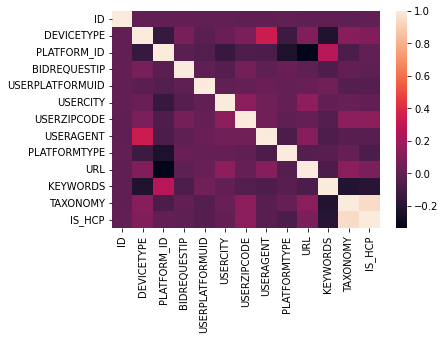

In [38]:
sns.heatmap(data=corr_mat,xticklabels=data.columns,yticklabels=data.columns)

### Inferences:

- High correlatio